# Research Project Experiment

In [1]:
# import
import torch.nn as nn
import torch
import snntorch as snn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt
import pandas as pd

Matplotlib is building the font cache; this may take a moment.


In [2]:
# dataloader arguments
batch_size = 128 
data_path='./data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
## if you're on M1 or M2 GPU:
# device = torch.device("mps")

In [ ]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.KMNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.KMNIST(data_path, train=False, download=True, transform=transform)
# datasets.

RuntimeError: Error downloading train-images-idx3-ubyte.gz:
Tried http://codh.rois.ac.jp/kmnist/dataset/kmnist/, got:
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>


In [69]:
# Create DataLoaders
# train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [70]:
# Network Architecture
num_inputs = 28*28
# num_hidden = 500 # vary
num_outputs = 10

# Temporal Dynamics
# num_steps = 25 # vary
# beta = 0.95 # vary 

In [71]:
# Define Network
class Net(nn.Module):
    def __init__(self, num_hidden, new_beta, num_steps):
    # def __init__(self):

        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=new_beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=new_beta)
        self.num_steps = num_steps

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(self.num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        
# Load the network onto CUDA if available
# net = Net(500, 0.95).to(device)

In [72]:
# loss = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

# num_epochs = 1
# loss_hist = []
# test_loss_hist = []
# counter = 0

# # Outer training loop
# for epoch in range(num_epochs):
#     train_batch = iter(train_loader)

#     # Minibatch training loop
#     for data, targets in train_batch:
#         data = data.to(device)
#         targets = targets.to(device)

#         # forward pass
#         net.train()
#         spk_rec, _ = net(data.flatten(1))

#         # initialize the loss & sum over time
#         loss_val = torch.zeros((1), dtype=dtype, device=device)
#         loss_val += loss(spk_rec.sum(0), targets)

#         # Gradient calculation + weight update
#         optimizer.zero_grad()
#         loss_val.backward()
#         optimizer.step()

#         # Store loss history for future plotting
#         loss_hist.append(loss_val.item())

#         # Print train/test loss/accuracy
#         if counter % 10 == 0:
#             print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
#         counter += 1

#         if counter == 50:
#           break

In [73]:
def measure_accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
      data = data.to(device)
      targets = targets.to(device)

      # forward-pass
      spk_rec, _ = model(data.flatten(1))
      spike_count = spk_rec.sum(0)
      _, max_spike = spike_count.max(1)

      # correct classes for one batch
      num_correct = (max_spike == targets).sum()

      # total accuracy
      running_length += len(targets)
      running_accuracy += num_correct
    
    accuracy = (running_accuracy / running_length)

    return accuracy.item()


In [74]:
# print(f"Test set accuracy: {measure_accuracy(net, test_loader)}")

In [75]:
def calc_fitness(batch_size, num_hidden, beta, num_steps):
    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

    net = Net(num_hidden, beta, num_steps).to(device)
    loss = nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

    num_epochs = 1
    loss_hist = []
    test_loss_hist = []
    counter = 0

    # Outer training loop
    for epoch in range(num_epochs):
        train_batch = iter(train_loader)

        # Minibatch training loop
        for data, targets in train_batch:
            data = data.to(device)
            targets = targets.to(device)

            # forward pass
            net.train()
            spk_rec, _ = net(data.flatten(1))

            # initialize the loss & sum over time
            loss_val = torch.zeros((1), dtype=dtype, device=device)
            loss_val += loss(spk_rec.sum(0), targets)

            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())

            # Print train/test loss/accuracy
            if counter % 10 == 0:
                print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
            counter += 1

            # if counter == 50:
            #     break
    return measure_accuracy(net, test_loader)

In [ ]:
# CS 420/CS 527 Lab 2: Genetic Algorithms in LEAP 
# Author: Catherine Schuman
# February 2022

evaluation_log = []  # Global list to store rows for dataframe

import os
import numpy as np
from toolz import pipe

from leap_ec import Individual, context, test_env_var
from leap_ec import ops, probe, util
from leap_ec.decoder import IdentityDecoder
from leap_ec.binary_rep.problems import MaxOnes
from leap_ec.binary_rep.initializers import create_binary_sequence
from leap_ec.binary_rep.ops import mutate_bitflip
from leap_ec.binary_rep.problems import ScalarProblem
import argparse
import sys

# Implementation of a custom problem
class Lab2Problem(ScalarProblem):
    def __init__(self):
        super().__init__(maximize=True)
        
    def evaluate(self, ind):
        
        binary_str = ''.join(['1' if b else '0' for b in ind])

        # Bit slices
        batch_bits   = int(binary_str[0:3], 2)    # 3 bits = 0–7
        hidden_bits  = int(binary_str[3:9], 2)    # 6 bits = 0–63
        beta_bits    = int(binary_str[9:14], 2)   # 5 bits = 0–31
        steps_bits   = int(binary_str[14:17], 2)  # 3 bits = 0–7

        # Map to real hyperparameters
        batch_size  = 64 + (batch_bits % 7) * 32         # 64, 96, ..., 256
        num_hidden = 200 + (hidden_bits % 41) * 20      # 200–1000
        beta        = round(0.5 + (beta_bits / 31) * (0.99 - 0.5), 4)  # 0.5–0.99
        num_steps   = 10 + (steps_bits % 5) * 10

        accuracy = calc_fitness(batch_size=batch_size, num_hidden=num_hidden, beta=beta, num_steps=num_steps)

        evaluation_log.append({
            "generation": context.generation,
            "batch_size": batch_size,
            "num_hidden": num_hidden,
            "beta": beta,
            "num_steps": num_steps,
            "accuracy": accuracy
        })

        # return calc_fitness()
        return accuracy


# if __name__ == '__main__':
#     parser = argparse.ArgumentParser(description="Lab 2: Genetic Algorithms")
#     parser.add_argument("--n", default=50, help="population size", type=int)
#     parser.add_argument("--p_m", default=0.01, help="probability of mutation", type=float)
#     parser.add_argument("--p_c", default=0.3, help="probability of crossover", type=float)
#     parser.add_argument("--trn_size", default=2, help="tournament size", type=int)
#     parser.add_argument("--csv_output", required=True, help="csv output file name", type=str)
#     args = parser.parse_args()    

N = 25
p_m = 0.01
p_c = 0.3
trn_size = 3

max_generation = 30
l = 17
parents = Individual.create_population(N,
                                       initialize=create_binary_sequence(
                                           l),
                                       decoder=IdentityDecoder(),
                                       problem=Lab2Problem())

# Evaluate initial population
parents = Individual.evaluate_population(parents)

generation_counter = util.inc_generation()
out_f = open(args.csv_output, "w")
while generation_counter.generation() < max_generation:
    offspring = pipe(parents,
                     ops.tournament_selection(k=trn_size),
                     ops.clone,
                     mutate_bitflip(probability=p_m),
                     ops.UniformCrossover(p_xover=p_c),
                     ops.evaluate,
                     ops.pool(size=len(parents)),  # accumulate offspring
                     probe.AttributesCSVProbe(stream=out_f, do_fitness=True, do_genome=True)
                    )
    
    parents = offspring
    generation_counter()  # increment to the next generation

out_f.close()
df = pd.DataFrame(evaluation_log)
df.to_csv("evolution_log.csv", index=False)

In [76]:
# Call fitness function for both models (when training logic is finished inside it)
baseline_acc = calc_fitness(
    batch_size=128,
    num_hidden=500,
    beta=0.95,
    num_steps=25
)

evolved_acc = calc_fitness(
    batch_size=128,
    num_hidden=650,  # example evolved values
    beta=0.90,
    num_steps=30
)

Iteration: 0 	 Train Loss: 2.835314989089966
Iteration: 10 	 Train Loss: 1.3845243453979492
Iteration: 20 	 Train Loss: 0.9968311190605164
Iteration: 30 	 Train Loss: 1.0909626483917236
Iteration: 40 	 Train Loss: 0.7903536558151245
Iteration: 50 	 Train Loss: 1.0927057266235352
Iteration: 60 	 Train Loss: 0.8945329189300537
Iteration: 70 	 Train Loss: 0.8525330424308777
Iteration: 80 	 Train Loss: 0.8438796997070312
Iteration: 90 	 Train Loss: 0.8458335995674133
Iteration: 100 	 Train Loss: 0.7510735392570496
Iteration: 110 	 Train Loss: 0.6640778183937073
Iteration: 120 	 Train Loss: 0.4387333393096924
Iteration: 130 	 Train Loss: 0.5425313115119934
Iteration: 140 	 Train Loss: 0.81395024061203
Iteration: 150 	 Train Loss: 0.4554436206817627
Iteration: 160 	 Train Loss: 0.3872653841972351
Iteration: 170 	 Train Loss: 0.40704280138015747
Iteration: 180 	 Train Loss: 0.2819400131702423
Iteration: 190 	 Train Loss: 0.28633424639701843
Iteration: 200 	 Train Loss: 0.2993703782558441
Iter

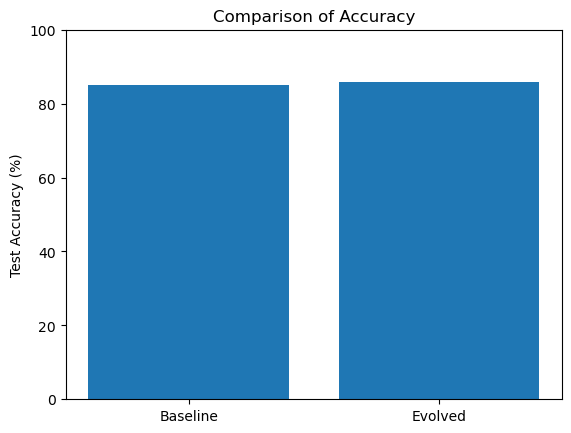

In [ ]:
plt.bar(["Baseline", "Evolved"], [baseline_acc * 100, evolved_acc * 100])
plt.ylabel("Test Accuracy (%)")
plt.title("Comparison of Accuracy")
plt.ylim(0, 100)
plt.show()

In [ ]:
df = pd.read_csv("evolution_log.csv")
# plot best accuracy per generation
best_by_gen = df.groupby("generation")["accuracy"].max()
plt.plot(best_by_gen.index, best_by_gen.values)
plt.xlabel("Generation")
plt.ylabel("Best Accuracy (%)")
plt.title("Evolution Progress")
plt.grid(True)
plt.show()

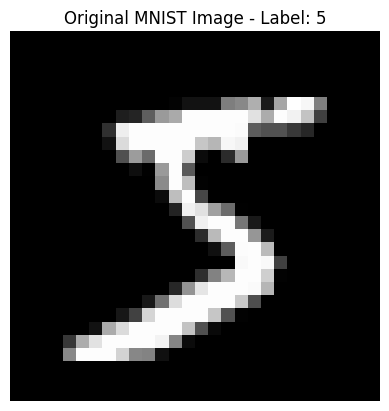

Spikes over time for pixel (14,14):
[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]


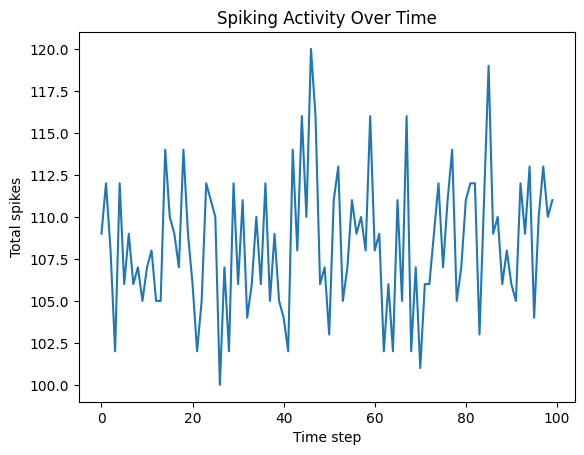

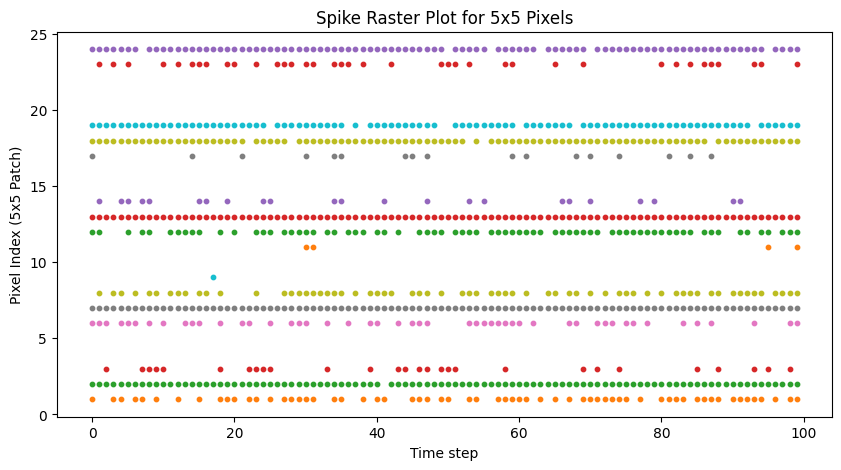

In [ ]:
# # SNN Practice with MNIST and Rate Encoding
# import torch
# from torchvision import datasets, transforms
# import numpy as np
# import matplotlib.pyplot as plt

# # Step 1: Load one MNIST image (as grayscale 28x28)
# transform = transforms.Compose([transforms.ToTensor()])
# mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# image, label = mnist[0]  # Just take the first image for example
# image = image.squeeze()  # Remove extra channel dimension (1, 28, 28) -> (28, 28)

# # Step 2: Show the original MNIST image
# plt.imshow(image, cmap='gray')
# plt.title(f"Original MNIST Image - Label: {label}")
# plt.axis('off')
# plt.show()

# # Step 3: Normalize pixel values to [0, 1] to use as firing probabilities
# normalized_image = image.numpy()  # Convert tensor to numpy array
# normalized_image = normalized_image / normalized_image.max()  # Ensure values between 0 and 1

# # Step 4: Encode to spikes over T time steps
# T = 100  # Total simulation time steps
# spike_train = np.zeros((T, 28, 28))

# for t in range(T):
#     # Flip a coin for each pixel: will it spike at time t?
#     spikes = np.random.rand(28, 28) < normalized_image
#     spike_train[t] = spikes

# # Step 5: Visualize spike activity over time for one pixel
# pixel_row, pixel_col = 14, 14  # Pick center pixel
# pixel_spike_times = spike_train[:, pixel_row, pixel_col]

# print(f"Spikes over time for pixel ({pixel_row},{pixel_col}):")
# print(pixel_spike_times.astype(int))

# # Step 6: Plot total number of spikes at each time step (activity curve)
# total_spikes = spike_train.sum(axis=(1, 2))
# plt.figure()
# plt.plot(range(T), total_spikes)
# plt.xlabel("Time step")
# plt.ylabel("Total spikes")
# plt.title("Spiking Activity Over Time")
# plt.show()

# # Step 7: Show a spike raster plot for a small 5x5 patch of pixels
# plt.figure(figsize=(10, 5))
# for i in range(5):
#     for j in range(5):
#         spikes = spike_train[:, 10+i, 10+j]
#         spike_times = np.where(spikes == 1)[0]
#         plt.scatter(spike_times, np.ones_like(spike_times) * (i*5 + j), s=10)

# plt.xlabel("Time step")
# plt.ylabel("Pixel Index (5x5 Patch)")
# plt.title("Spike Raster Plot for 5x5 Pixels")
# plt.show()